In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import processor
import hist
# from coffea import hist, processor 
# from coffea.hist import plot
from coffea.util import load, save
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
hists = {}
for year in ["2016preVFP","2016postVFP","2017","2018"]:
    hists[year] = load('../hists/hadmonotop'+year+'.merged')

In [3]:
###
# To find the a variable's working point
###

# iterating for each year
for year in hists.keys():
    previous = None

    variable = 'TvsQCD'
    acc = 0.9
    cut_bin = 0 
    done = False
    
    # getting attributes from arbitary mass combination
    arbitrary_key = next(iter(hists[year][variable].keys()))
    nbins = hists[year][variable][arbitrary_key].view().size
    cut_value_array = hists[year][variable][arbitrary_key][{"region":slice(0,len,sum)}].axes.edges[0]
    assert len(cut_value_array)==nbins+1, "this isn't redundant"

    print('-'*25)
    print('Variable:', variable)
    print('Year:', year)
    print('Threshold:'+str(acc*100)+"%")
    #print('------------------------')
    while not done:
        print('-'*15)
        print(variable,'> %.2f' % cut_value_array[cut_bin+1])
        print('-'*15)
        print("Look to check that the following values are all close")
        # finding 5 values
        for i,p in enumerate(hists[year][variable].keys()):
            yld_array = hists[year][variable][p][{"region":slice(0,len,sum)}].values()
            yld = yld_array.sum()
            total = yld
            yld = yld - np.cumsum(yld_array)[cut_bin]
            ratio = yld / total
            print("ratio for {:0.2f} cut: {:0.2f}".format(cut_value_array[cut_bin+1],ratio))
            if i == 4: break
        # arbitrarily using last value to determine if this is the correct cut
        if (ratio < acc):
            # seeing if previous step was a better cut
            if (previous is not None) and (0.9-ratio > previous-0.9):
                cut_bin -= 1
            print('-'*15)
            print("Best cut for "+year+" is {:.2f} <- <- <-".format(cut_value_array[cut_bin+1]))
            print('-'*20)
            print('')
            done = True
        else:
            previous = ratio
            cut_bin += 1
            if cut_bin == nbins: 
                print('-'*15)
                print("Could not find cut")
                print('-'*25)
                print('')
                done = True


-------------------------
Variable: TvsQCD
Year: 2016preVFP
Threshold:90.0%
---------------
TvsQCD > 0.07
---------------
Look to check that the following values are all close
ratio for 0.07 cut: 0.77
ratio for 0.07 cut: 0.79
ratio for 0.07 cut: 0.75
ratio for 0.07 cut: 0.79
ratio for 0.07 cut: 0.78
---------------
Best cut for 2016preVFP is 0.07 <- <- <-
--------------------

-------------------------
Variable: TvsQCD
Year: 2016postVFP
Threshold:90.0%
---------------
TvsQCD > 0.07
---------------
Look to check that the following values are all close
ratio for 0.07 cut: 0.78
ratio for 0.07 cut: 0.79
ratio for 0.07 cut: 0.75
ratio for 0.07 cut: 0.78
ratio for 0.07 cut: 0.78
---------------
Best cut for 2016postVFP is 0.07 <- <- <-
--------------------

-------------------------
Variable: TvsQCD
Year: 2017
Threshold:90.0%
---------------
TvsQCD > 0.07
---------------
Look to check that the following values are all close
ratio for 0.07 cut: 0.79
ratio for 0.07 cut: 0.80
ratio for 0.07 cut

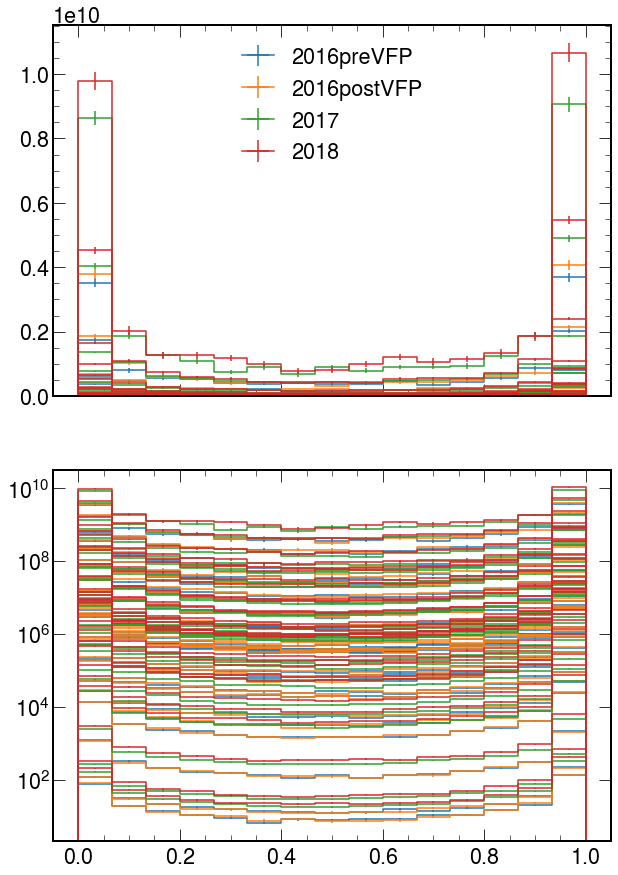

In [4]:
# These are all cutting on the first bin. Why?

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,15),sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_year = {"2016preVFP":colors[0],"2016postVFP":colors[1],"2017":colors[2],"2018":colors[3]}

for year in hists.keys():
    # getting attributes from arbitary mass combination
    arbitrary_key = next(iter(hists[year][variable].keys()))
    #for i,p in enumerate(hists[year][variable].keys()):
    #    hists[year][variable][p][{"region":sum}].plot()
    #counts, _, bins = hists[year][variable][arbitrary_key].to_numpy()
    #ax.hist(counts[0],bins,label="year")
    for i,p in enumerate(hists[year][variable].keys()):
        if i==0: 
            hists[year][variable][p][{"region":sum}].plot(ax=ax1,color=color_year[year],label=year)
            hists[year][variable][p][{"region":sum}].plot(ax=ax2,color=color_year[year],label=year)
        else: 
            hists[year][variable][p][{"region":sum}].plot(ax=ax1,color=color_year[year])
            hists[year][variable][p][{"region":sum}].plot(ax=ax2,color=color_year[year])
ax1.legend()
ax2.set_yscale("log")
plt.draw()


In [5]:
# The all have fairly well-shared extreme skewing, meaning the first bin
# always has >10% of the counts, so the cut is always on the first bin